# start

In [1]:
import os
import pandas as pd
import numpy as np
import time
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import ChemicalFeatures
from rdkit import RDConfig
import tensorflow as tf
import torch
import torch.nn as nn
from collections import defaultdict
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from rdkit.Chem.rdmolops import FastFindRings
from torch.nn import Parameter
import dgl
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

Using backend: pytorch[15:09:17] /opt/dgl/src/runtime/tensordispatch.cc:43: TensorDispatcher: dlopen failed: /root/anaconda3/lib/python3.8/site-packages/dgl/tensoradapter/pytorch/libtensoradapter_pytorch_1.11.0.so: cannot open shared object file: No such file or directory



In [2]:
data_file = '../data1/data1.csv'
mol_dir = '../data1/data1_sdf_files/'

In [3]:
def Nodes_feat(mol):

    atom_feats_dict = defaultdict(list)
    is_donor = defaultdict(int)
    is_acceptor = defaultdict(int)
    
    
    fdef_name = os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef')
    mol.UpdatePropertyCache()
    FastFindRings(mol)
    mol_featurizer = ChemicalFeatures.BuildFeatureFactory(fdef_name)
    
    mol_feats = mol_featurizer.GetFeaturesForMol(mol)
    mol_conformers = mol.GetConformers()
       
    assert len(mol_conformers) == 1
    geom = mol_conformers[0].GetPositions()
    
    
    for i in range(len(mol_feats)):
        if mol_feats[i].GetFamily() == 'Donor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_donor[u] = 1
        elif mol_feats[i].GetFamily() == 'Acceptor':
            node_list = mol_feats[i].GetAtomIds()
            for u in node_list:
                is_acceptor[u] = 1
    
    num_atoms = mol.GetNumAtoms()
    
    atoms = mol.GetAtoms()
    AllChem.ComputeGasteigerCharges(mol)
    atom_types = [atom.GetAtomicNum() for atom in atoms]
    rdkit_period_table = Chem.GetPeriodicTable()
    radius = np.array([rdkit_period_table.GetRvdw(item) for item in atom_types])
    charge=[atom.GetDoubleProp('_GasteigerCharge') for atom in atoms]

    
    conformer = mol.GetConformer()
    positions = conformer.GetPositions()
    h_u = []    
    for u in range(num_atoms):
        ato = mol.GetAtomWithIdx(u)
        symbol = ato.GetSymbol()
        atom_type = ato.GetAtomicNum()
        aromatic = ato.GetIsAromatic()
        hybridization = ato.GetHybridization()
        #print(u)

        
        num_h = ato.GetTotalNumHs()#相连氢原子个数
        atom_feats_dict['pos'].append(torch.FloatTensor(geom[u]))
        atom_feats_dict['node_type'].append(atom_type)
       
       
        h_u += [
            int(symbol == x) for x in ['H', 'C', 'N', 'O', 'F', 'S', 'Cl']
        ]
        h_u.append(atom_type)
        h_u.append(is_acceptor[u])
        h_u.append(is_donor[u])
        h_u.append(int(aromatic))
        h_u += [
            int(hybridization == x)
            for x in (Chem.rdchem.HybridizationType.SP,
                      Chem.rdchem.HybridizationType.SP2,
                      Chem.rdchem.HybridizationType.SP3)
        ]
        h_u.append(num_h)
    h_u=np.array(h_u).reshape(-1,15)
    return h_u

In [4]:
def Get_DGL(sdf_file='',rdkit_mol=None,spms_acc=40,elec_acc=10,removeHs=False,spms_radius=None):
    
    if sdf_file != '':
        if removeHs:
            mol = Chem.MolFromMolFile(sdf_file,removeHs=True,sanitize=False)
        else:
            mol = Chem.MolFromMolFile(sdf_file,removeHs=False,sanitize=False)
    elif rdkit_mol != None:
        mol = rdkit_mol
        
    atoms = mol.GetAtoms()
    atom_symbols = [atom.GetSymbol() for atom in atoms]
    bonds = mol.GetBonds()
    edges = [[bond.GetBeginAtomIdx(),bond.GetEndAtomIdx()] for bond in bonds]
    pos = mol.GetConformer().GetPositions()
    
    G = nx.Graph()
    G.add_nodes_from(list(range(0,len(atom_symbols))))
    G.add_edges_from(edges)
    if dgl.__version__ == '0.4.3post2':
        dgl_g = dgl.graph(G)
    else:
        dgl_g=dgl.from_networkx(G)
    #dgl_g= dgl.add_self_loop(dgl_g)
    all_edges_0,all_edges_1 = dgl_g.all_edges()
    dist = np.array([np.linalg.norm(pos[int(all_edges_0[i])]-pos[int(all_edges_1[i])]) for i in range(len(all_edges_0))]).reshape(-1,1)
    dist = torch.tensor(dist,dtype=torch.float32)
    #dgl_g.ndata['feat'] = feat
    dgl_g.edata['feat'] = dist
    return dgl_g

In [5]:
def sort_func(x): return eval(x.split('/')[-1].split('.')[0].split('_')[-1])
lig_files = sorted(glob.glob(mol_dir+'lig_*.sdf'),key=sort_func)
add_files = sorted(glob.glob(mol_dir+'add_*.sdf'),key=sort_func)
base_files = sorted(glob.glob(mol_dir+'base_*.sdf'),key=sort_func)
ar_ha_files = sorted(glob.glob(mol_dir+'ar_ha_*.sdf'),key=sort_func)

#cat_files=[x.split('/')[-1].split('.')[0] for x in cat_files]
#imine_files=[x.split('/')[-1].split('.')[0] for x in imine_files]
#thiol_files=[x.split('/')[-1].split('.')[0] for x in thiol_files]

sdf_file=lig_files+add_files+base_files+ar_ha_files
with open(mol_dir+'smiles_file_dict.csv','r') as fr:
    lines = fr.readlines()
smiles_name_dict = {tmp_line.strip().split(',')[0]:tmp_line.strip().split(',')[1] for tmp_line in lines}

In [6]:
def Calc_feat(file_list):
    
    #all_atom_feats=[]
    file_graph_dict = {}
    for index, tmp_file in enumerate(file_list):
        tmp_fn = tmp_file.split('/')[-1].split('.')[0]
        tmp_g = Get_DGL(tmp_file)
        file_graph_dict[tmp_fn] = tmp_g
        #feat_name_dict[tmp_fn] = index
        mol = Chem.MolFromMolFile(tmp_file,removeHs=False)
        num_atoms = mol.GetNumAtoms()
        print(tmp_file)
        atom_feats= Nodes_feat(mol)
        atom_feats = torch.tensor(atom_feats,dtype=torch.float32)
        tmp_g.ndata['feat'] = atom_feats

    return file_graph_dict

In [7]:
lig_Graph_name_dict=Calc_feat(lig_files)

../data1/data1_sdf_files/lig_0.sdf
../data1/data1_sdf_files/lig_1.sdf
../data1/data1_sdf_files/lig_2.sdf
../data1/data1_sdf_files/lig_3.sdf


In [8]:
ar_ha_Graph_name_dict=Calc_feat(ar_ha_files)

../data1/data1_sdf_files/ar_ha_0.sdf
../data1/data1_sdf_files/ar_ha_1.sdf
../data1/data1_sdf_files/ar_ha_2.sdf
../data1/data1_sdf_files/ar_ha_3.sdf
../data1/data1_sdf_files/ar_ha_4.sdf
../data1/data1_sdf_files/ar_ha_5.sdf
../data1/data1_sdf_files/ar_ha_6.sdf
../data1/data1_sdf_files/ar_ha_7.sdf
../data1/data1_sdf_files/ar_ha_8.sdf
../data1/data1_sdf_files/ar_ha_9.sdf
../data1/data1_sdf_files/ar_ha_10.sdf
../data1/data1_sdf_files/ar_ha_11.sdf
../data1/data1_sdf_files/ar_ha_12.sdf
../data1/data1_sdf_files/ar_ha_13.sdf
../data1/data1_sdf_files/ar_ha_14.sdf


In [9]:
base_Graph_name_dict=Calc_feat(base_files)

../data1/data1_sdf_files/base_0.sdf
../data1/data1_sdf_files/base_1.sdf
../data1/data1_sdf_files/base_2.sdf


In [10]:
add_Graph_name_dict=Calc_feat(add_files)

../data1/data1_sdf_files/add_0.sdf
../data1/data1_sdf_files/add_1.sdf
../data1/data1_sdf_files/add_2.sdf
../data1/data1_sdf_files/add_3.sdf
../data1/data1_sdf_files/add_4.sdf
../data1/data1_sdf_files/add_5.sdf
../data1/data1_sdf_files/add_6.sdf
../data1/data1_sdf_files/add_7.sdf
../data1/data1_sdf_files/add_8.sdf
../data1/data1_sdf_files/add_9.sdf
../data1/data1_sdf_files/add_10.sdf
../data1/data1_sdf_files/add_11.sdf
../data1/data1_sdf_files/add_12.sdf
../data1/data1_sdf_files/add_13.sdf
../data1/data1_sdf_files/add_14.sdf
../data1/data1_sdf_files/add_15.sdf
../data1/data1_sdf_files/add_16.sdf
../data1/data1_sdf_files/add_17.sdf
../data1/data1_sdf_files/add_18.sdf
../data1/data1_sdf_files/add_19.sdf
../data1/data1_sdf_files/add_20.sdf
../data1/data1_sdf_files/add_21.sdf


# dataset

In [11]:
from torch.utils.data import Dataset
class Graph_DataSet(Dataset):

    def __init__(self, root, train=True, transform = None, target_transform=None):
        super(Graph_DataSet, self).__init__()
        self.train = train
        self.transform = transform
        self.target_transform = target_transform

        #如果是训练则加载训练集，如果是测试则加载测试集
        if self.train :
            file_annotation = root + '/data1.csv' 
            sdf_folder = root + '/data1_sdf_files/'
        else:
            file_annotation = root + '/test.csv' 
            sdf_folder = root + '/test_sdf/'
        df = pd.read_csv(file_annotation)
 
        #data_dict = df[['molecule','CV']]
        target = np.array(df['Output'].to_list())
        self.target_min = target.min()
        self.target_range = target.max() - target.min()
        
        target_std = (target - target.min())/(target.max()-target.min())
        
        lig_smi = df['Ligand'].to_list()
        add_smi = df['Additive'].to_list()
        base_smi = df['Base'].to_list()
        ar_ha_smi = df['Aryl halide'].to_list()
        
        lig_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in lig_smi]
        add_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in add_smi]
        base_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in base_smi]
        ar_ha_file_names = [smiles_name_dict[tmp_smi] for tmp_smi in ar_ha_smi]
        
        self.lig_file_names = lig_file_names
        self.add_file_names = add_file_names
        self.base_file_names = base_file_names
        self.ar_ha_file_names = ar_ha_file_names
        
        self.target_std = target_std
        self.sdf_folder = sdf_folder
            
    def __getitem__(self, index):
        #mol_name = self.filenames[index]
        lig_name = self.lig_file_names[index]
        add_name = self.add_file_names[index]
        base_name = self.base_file_names[index]
        ar_ha_name = self.ar_ha_file_names[index]
        label = self.target_std[index]

        graph_1 = lig_Graph_name_dict[lig_name]
        graph_2 = add_Graph_name_dict[add_name]
        graph_3 = base_Graph_name_dict[base_name]
        graph_4 = ar_ha_Graph_name_dict[ar_ha_name]
        return [graph_1,graph_1.ndata['feat'],graph_2,graph_2.ndata['feat'],graph_3,graph_3.ndata['feat'],graph_4,graph_4.ndata['feat']], label

    def __len__(self):
        return len(self.target_std)

# model

In [12]:
class StochasticTwoLayerGCN(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()      
        
        #self.conv1 = dgl.nn.SGConv(in_features, hidden_features,  k=2, cached=True)
        #self.conv2 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        #self.conv3 = dgl.nn.SGConv(hidden_features, hidden_features, k=2, cached=True)
        
        #self.conv1 = dgl.nn.SAGEConv(in_features, hidden_features, 'pool')
        #self.conv2 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
        #self.conv3 = dgl.nn.SAGEConv(hidden_features, hidden_features, 'pool')
                
        #self.conv1 = dgl.nn.EdgeConv(in_features, hidden_features)
        #self.conv2 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        #self.conv3 = dgl.nn.EdgeConv(hidden_features, hidden_features)
        
        #self.conv1 = dgl.nn.GATConv(in_features, hidden_features, num_heads=3)
        #self.conv2 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        #self.conv3 = dgl.nn.GATConv(hidden_features, hidden_features, num_heads=3)
        
        #self.conv1 = dgl.nn.TAGConv(in_features, hidden_features, k=4)
        #self.conv2 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        #self.conv3 = dgl.nn.TAGConv(hidden_features, hidden_features, k=4)
        
        #self.conv1 = dgl.nn.RelGraphConv(in_features, hidden_features, 4, num_bases=4)
        #self.conv2 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4 , num_bases=4)
        #self.conv3 = dgl.nn.RelGraphConv(hidden_features, hidden_features,4, num_bases=4)
        #etype = np.ones(186).astype(np.int64)
        
        self.conv1 = dgl.nn.GraphConv(in_features, hidden_features)
        self.conv2 = dgl.nn.GraphConv(hidden_features, hidden_features)
        self.conv3 = dgl.nn.GraphConv(hidden_features, hidden_features)
       
        self.fc1   = nn.Linear(304,128) 
        self.fc2   = nn.Linear(128, 64)
        self.fc3   = nn.Linear(64, 1)

    def forward(self,g1,x1,g2,x2,g3,x3,g4,x4,multi_graph_opt='mean',output_opt='mean'):
        
        x1 = F.relu(self.conv1(g1, x1))
        x1 = F.relu(self.conv2(g1, x1))
        x1 = F.relu(self.conv3(g1, x1))
        #x1=torch.mean(x1,axis=0).reshape(-1,1)
        #x1t=x1.transpose(-1,0)
        #x1t=x1.reshape(-1,200)
       
        x2 = F.relu(self.conv1(g2, x2))
        x2 = F.relu(self.conv2(g2, x2))
        x2 = F.relu(self.conv3(g2, x2))
        #x2=torch.mean(x2,axis=0).reshape(-1,1)
        #x2t=x2.transpose(-1,0)
        #x2t=x2.reshape(-1,200)
        
        x3 = F.relu(self.conv1(g3, x3))
        x3 = F.relu(self.conv2(g3, x3))
        x3 = F.relu(self.conv3(g3, x3))
        #x3=torch.mean(x3,axis=0).reshape(-1,1)
        #x3t=x3.transpose(-1,0)
        #x3t=x3.reshape(-1,200)
        x4 = F.relu(self.conv1(g4, x4))
        
        if multi_graph_opt == 'mean':
            x = torch.mean(torch.cat([x1,x2,x3,x4],axis=0),axis=0)
           
        elif multi_graph_opt == 'sum':
            x = torch.sum(torch.cat([x1,x2,x3,x4],axis=0),axis=0)
        
        if output_opt == 'mean':
            x = F.torch.mean(x)
        elif output_opt == 'sum':
            x = F.torch.sum(x)
        '''x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))'''
        
        return x

# train

In [13]:
loss = 'mse'
batch_size = 64
shuffle = np.array(list(range(3955)))
np.random.shuffle(shuffle)
train_index = shuffle[:2769]
val_index = shuffle[2769:]
dataset = Graph_DataSet('../data1')
train_data=[]
for i in train_index:
    tem_data=dataset[i]
    train_data.append(tem_data)
    
val_data=[]
for i in val_index:
    tem_data=dataset[i]
    val_data.append(tem_data) 

In [14]:
import tensorflow as tf
model = StochasticTwoLayerGCN(15,256,1)
#optimizer = optim.Adam(model.parameters())
#loss_func = torch.nn.L1Loss()
optimizer = optim.Adam(model.parameters())
loss_func = torch.nn.L1Loss()
all_test=[]
all_pred=[]
for epoch in range(50):
    get_output=[]
    all_loss = []
    model.train()
    for i, data in enumerate(train_data):
        inputs, labels = data

        # zero the parameter gradients
        

        # forward + backward + optimize
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        get_output.append(outputs)

        labels = torch.tensor(labels) 
        
        loss = loss_func(outputs, labels)
        optimizer.zero_grad()
        all_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
    print(epoch,'Train MAE',np.mean(all_loss))
    model.eval()
    test_get_output=[]
    test_all_labels = []
    all_loss = []
    for data in val_data:
        inputs, labels = data
        outputs = model(inputs[0],inputs[1],
                        inputs[2],inputs[3],
                        inputs[4],inputs[5],
                        inputs[6],inputs[7],)
        test_get_output.append(outputs)
        labels = torch.tensor(labels) 
        test_all_labels.append(labels)
        loss = loss_func(outputs, labels)
        all_loss.append(loss.detach().numpy())
    all_test.append(test_all_labels)
    all_pred.append(test_get_output)
    print(epoch,'Test MAE',np.mean(all_loss))   

#hist = model.fit_generator(train_data,validation_data=val_data,epochs=100,callbacks=[checkpoint])

0 Train MAE 0.23608753
0 Test MAE 0.22906104
1 Train MAE 0.23255819
1 Test MAE 0.22127262
2 Train MAE 0.22799882
2 Test MAE 0.2163577
3 Train MAE 0.22340141
3 Test MAE 0.21393979
4 Train MAE 0.21999083
4 Test MAE 0.21361594
5 Train MAE 0.21792062
5 Test MAE 0.21149959
6 Train MAE 0.21677391
6 Test MAE 0.20995966
7 Train MAE 0.21561797
7 Test MAE 0.20992091
8 Train MAE 0.21429913
8 Test MAE 0.20862934
9 Train MAE 0.2132988
9 Test MAE 0.20762962
10 Train MAE 0.212145
10 Test MAE 0.20681654
11 Train MAE 0.21064632
11 Test MAE 0.20442995
12 Train MAE 0.20937364
12 Test MAE 0.20416544
13 Train MAE 0.20912166
13 Test MAE 0.20351517
14 Train MAE 0.20785299
14 Test MAE 0.20235138
15 Train MAE 0.20735139
15 Test MAE 0.202069
16 Train MAE 0.20654416
16 Test MAE 0.20129722
17 Train MAE 0.20545867
17 Test MAE 0.20014262
18 Train MAE 0.204832
18 Test MAE 0.19857796
19 Train MAE 0.20358342
19 Test MAE 0.1982802
20 Train MAE 0.2026432
20 Test MAE 0.19694309
21 Train MAE 0.20179851
21 Test MAE 0.19649

In [20]:
all_rmse=[]
all_r2=[]
all_test_=[]
all_pred_=[]
for m in list(range(40,50)):
    test_all_labels_=[]
    for i in all_test[m]:
        test_all_labels_.append(i.tolist())

    test_get_output_=[]
    for i in all_pred[m]:
        test_get_output_.append(i.tolist())
    y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
    y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()  
    rmse=np.round((mean_squared_error(y_val,y_pred))**(0.5),3)
    r2=np.round(r2_score(y_val,y_pred),3)
    all_test_.append(test_all_labels_)
    all_pred_.append(test_get_output_)
    all_rmse.append(rmse)
    all_r2.append(r2)
    print(rmse,r2)

23.509 0.237
23.416 0.243
23.382 0.245
23.313 0.25
23.305 0.25
23.353 0.247
23.321 0.249
23.411 0.243
23.253 0.254
23.462 0.24


In [21]:
np.mean(all_rmse),np.mean(all_r2)

(23.372499999999995, 0.24580000000000002)

In [18]:
np.save('./dataset/data1_MG_GCN_all_test',all_test_)
np.save('./dataset/data1_MG_GCN_all_pred',all_pred_)

In [24]:
test_all_labels_=[]
for i in all_test_[2]:
    test_all_labels_.append(i.tolist())
    
test_get_output_=[]
for i in all_pred_[2]:
    test_get_output_.append(i.tolist())

AttributeError: 'float' object has no attribute 'tolist'

In [ ]:
all_test_[2]

In [16]:
tmp_df = pd.read_csv(data_file)
labels_ori = tmp_df['Output'].to_list()
labels_ori=np.array(labels_ori)
label_std = (np.array(labels_ori)-np.min(labels_ori))/(np.max(labels_ori)-np.min(labels_ori))

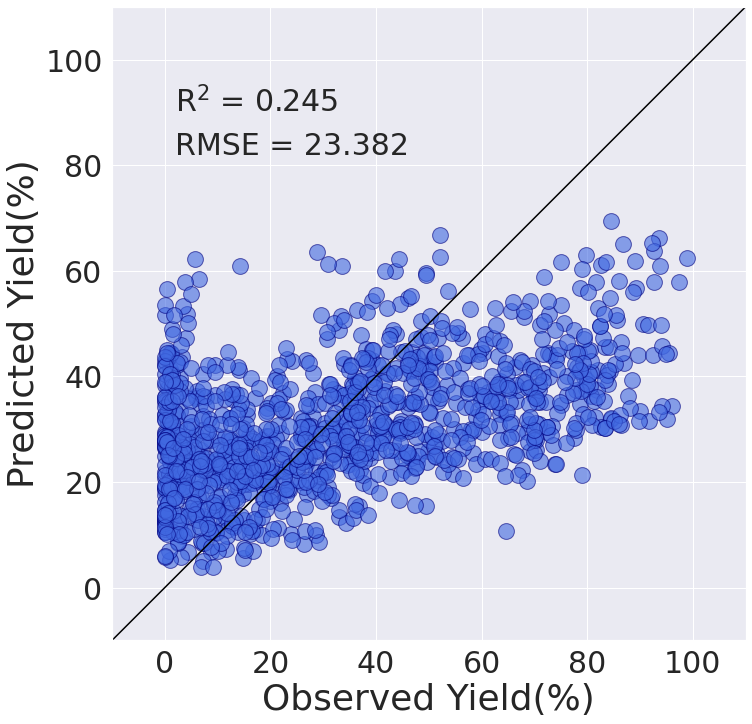

In [26]:
y_val=np.array(test_all_labels_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(test_get_output_)*(labels_ori.max()-labels_ori.min())+labels_ori.min()
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import matplotlib.pyplot as plt
sns.set(style='darkgrid')

y_val=np.array(all_test_[2])*(labels_ori.max()-labels_ori.min())+labels_ori.min()
y_pred=np.array(all_pred_[2])*(labels_ori.max()-labels_ori.min())+labels_ori.min()

import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
sns.set(style='darkgrid')
fig = plt.figure(figsize=(11,11),facecolor='white',    # 图表区的背景色
           edgecolor='black')
plt.scatter(y_val,y_pred,s=250, c='royalblue', label="samples",alpha=0.6,edgecolors='navy')
plt.plot([-10,110],[-10,110],c='black')
plt.xlim(-10,110)
plt.ylim(-10,110)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(20)
ax=plt.gca()
#ax.set_facecolor('oldlace')#oldlace   mistyrose
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
#plt.title('doyle',fontsize=14)
plt.xlabel("Observed Yield(%)",fontsize=36)
plt.ylabel("Predicted Yield(%)",fontsize=36)
#plt.grid(c='white', linewidth=2)
plt.tick_params(labelsize=30)
plt.text(2,82,'RMSE = %.3f'%(mean_squared_error(y_val,y_pred))**(0.5),fontsize=30)
plt.text(2,90,'R$^2$ = %.3f'%r2_score(y_val,y_pred),fontsize=30)
#plt.text(-0.5,3.4,'Test Set R2: %.3f'%r2_score(y_val,y_pred),fontsize=24)


plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)
plt.show()

In [55]:
np.save( './dataset/doyle_15_GCN_y_val.npy',y_val)#./dataset
np.save( './dataset/doyle_15_GCN_y_pred.npy',y_pred)